<b> 3D GMOT force calculations </b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
from scipy.optimize import bisect #For root finding
import pylcp
import pylcp.atom as atom
from pylcp.common import progressBar

In [2]:
x0 = (6/1.4/15) # cm
k = 2*np.pi/780E-7 # cm^{-1}
kbar = k*x0

gamma = 2*np.pi*6e6
t0 = k*x0/gamma
print(x0, k, kbar, 1/gamma, t0)

mass = 86.909180527*cts.value('atomic mass constant')/(cts.hbar*(k*1e2)**2*t0)
print(mass)

0.2857142857142857 80553.65778435367 23015.33079552962 2.6525823848649224e-08 0.0006105006105006105
0.03454474231473474


In [13]:
det=-1.5
alpha = 1.0
s = 1.0

laserBeams = pylcp.laserBeams([
    {'kvec':np.array([0., 0., -1.]), 'pol':1, 's':s, 'delta':det, 'wb':0.03*x0}, #Primary beam facing downwards
    
    #(-1,0) order
    {'kvec':np.array([-0.79864, 0, 0.601815]), 'pol':1, 's':0.7*0.23*s, 'delta':det, 'wb':0.03*x0},
    {'kvec':np.array([-0.79864, 0, 0.601815]), 'pol':-1, 's':0.3*0.23*s, 'delta':det, 'wb':0.03*x0},
    
    #(1,0) order
    {'kvec':np.array([0.79864, 0, 0.601815]), 'pol':1, 's':0.7*0.23*s, 'delta':det, 'wb':0.03*x0},
    {'kvec':np.array([0.79864, 0, 0.601815]), 'pol':-1, 's':0.3*0.23*s, 'delta':det, 'wb':0.03*x0},
    
    #(0,-1) order
    {'kvec':np.array([0, -0.79864, 0.601815]), 'pol':1, 's':0.7*0.23*s, 'delta':det, 'wb':0.03*x0},
    {'kvec':np.array([0, -0.79864, 0.601815]), 'pol':-1, 's':0.3*0.23*s, 'delta':det, 'wb':0.03*x0},
    
    #(0,1) order
    {'kvec':np.array([0, 0.79864, 0.601815]), 'pol':1, 's':0.7*0.23*s, 'delta':det, 'wb':0.03*x0},
    {'kvec':np.array([0, 0.79864, 0.601815]), 'pol':-1, 's':0.3*0.23*s, 'delta':det, 'wb':0.03*x0},
    
    #(0,0) order
    {'kvec':np.array([0, 0, 1]), 'pol':1, 's':.8*s, 'delta':det, 'wb':0.03*x0}],
    #{'kvec':np.array([0, 0, 1]), 'pol':-1, 's':0.8*0.07*s, 'delta':det, 'wb':0.03*x0}],
    
    beam_type=pylcp.gaussianBeam
)

magField = pylcp.quadrupoleMagneticField(alpha)

# Use the heuristic equation (or comment it out):
eqn = pylcp.heuristiceq(laserBeams, magField, gamma=1, mass=mass)

# Define the atomic Hamiltonian:
#Hg, muqg = pylcp.hamiltonians.singleF(F=0, muB=1)
#He, muqe = pylcp.hamiltonians.singleF(F=1, muB=1)

#dq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

#hamiltonian = pylcp.hamiltonian(Hg, He, muqg, muqe, dq, mass=mass)

#eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)

In [14]:
dz = 0.1
dv = 0.1
z = np.arange(-20, 20+dz, dz)
v = np.arange(-20, 20+dv, dv)

Z, V = np.meshgrid(z, v)

Rfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), Z])
Vfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), V])

eqn.generate_force_profile([np.zeros(Z.shape), np.zeros(Z.shape), Z],
                           [np.zeros(V.shape), np.zeros(V.shape), V],
                           name='Fz', progress_bar=True);

Completed in 3:40.                                                  


Text(0, 0.5, '$v/(\\Gamma/k)$')

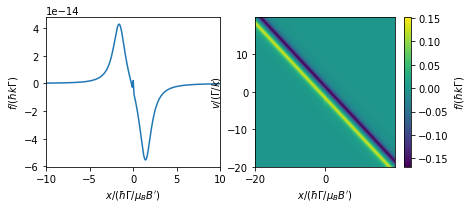

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, num="Expression", figsize=(6.5, 2.75))


ax[0].plot(z,eqn.profile['Fz'].F[2, int(np.ceil(z.shape[0]/2)), :]/gamma/k)
#ax[0].plot(x*(alpha/gamma), heuristiceq.profile['Fx'].F[0, int(np.ceil(x.shape[0]/2)), :]/gamma/k)
ax[0].set_ylabel('$f/(\hbar k \Gamma)$')
ax[0].set_xlabel('$x/(\hbar \Gamma/\mu_B B\')$')
ax[0].set_xlim((-10, 10))


im1 = ax[1].imshow(eqn.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
fig.subplots_adjust(left=0.08, wspace=0.2)
cb1 = plt.colorbar(im1)
cb1.set_label('$f/(\hbar k \Gamma)$')
ax[1].set_xlabel('$x/(\hbar \Gamma/\mu_B B\')$')
ax[1].set_ylabel('$v/(\Gamma/k)$')

In [109]:
v0s = np.arange(1, 15.5, 1)

# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=1e-5):
    if(y[-4]<threshold and y[-1]<1e-3):
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=1e-5):
    if y[-1]>20.:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal=True

sols = []
for v0 in v0s:
    eqn.set_initial_position_and_velocity(np.array([0., 0., z[0]]),
                                          np.array([0., 0., v0]))
    if isinstance(eqn, pylcp.rateeq):
        eqn.set_initial_pop(np.array([1., 0., 0., 0.]))

    eqn.evolve_motion([0., 100.], events=[captured_condition, lost_condition], max_step=0.1)

    sols.append(eqn.sol)

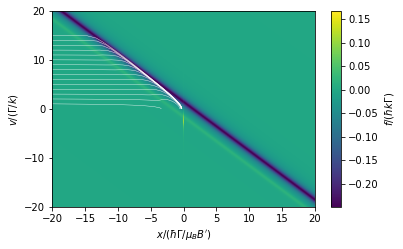

In [110]:
fig, ax = plt.subplots(1, 1)
plt.imshow(eqn.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$x/(\hbar \Gamma/\mu_B B\')$')
ax.set_ylabel('$v/(\Gamma/k)$')

fig.subplots_adjust(left=0.15, right=0.91, bottom=0.2)

for sol in sols:
    ax.plot(sol.r[2], sol.v[2], 'w-', linewidth=0.375)

ax.yaxis.set_ticks([-20, -10, 0, 10, 20])
# Display the figure at the end of the thing.
ax.set_xlim((-20, 20))
ax.set_xlim((-20, 20));